# YOLO Detection Inference

This notebook demonstrates YOLO object detection with bounding boxes and confidence scores.

In [50]:
# Configuration Parameters
model_path = r"C:\Users\76135\Desktop\ADSYS-Cardboard-AI-Detection\Versions\V2 Nanobanana Sythetic cardboard bundle dataset\models\weights\model_- 6 september 2025 11_35.pt"
image_path = r"C:\Users\76135\Desktop\ADSYS-Cardboard-AI-Detection\visy img\Picture3.png"
confidence_threshold = 0.1
iou_threshold = 0.10
device = "cuda"  # or "cuda" if GPU available

In [51]:
# Install required packages
# !pip install ultralytics opencv-python numpy pillow matplotlib

In [52]:
# Import libraries
import cv2
import numpy as np
from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [53]:
# Load YOLO model
model = YOLO(model_path)
print(f"Model loaded: {model_path}")
print(f"Model classes: {model.names if hasattr(model, 'names') else 'Unknown'}")

Model loaded: C:\Users\76135\Desktop\ADSYS-Cardboard-AI-Detection\Versions\V2 Nanobanana Sythetic cardboard bundle dataset\models\weights\model_- 6 september 2025 11_35.pt
Model classes: {0: 'bundle'}


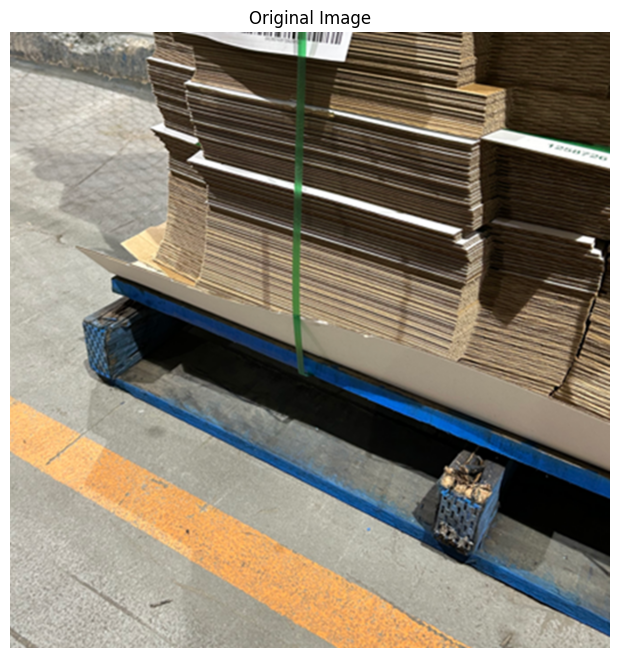

In [54]:
# Load and display input image
image = cv2.imread(image_path)
if image is None:
    raise ValueError(f"Could not load image from {image_path}")

# Convert BGR to RGB for matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 8))
plt.imshow(image_rgb)
plt.title('Original Image')
plt.axis('off')
plt.show()

In [55]:
# Run YOLO inference
results = model(
    image_path,
    conf=confidence_threshold,
    iou=iou_threshold,
    device=device,
    verbose=False
)

# Get detection results
result = results[0]
print(f"Detections: {len(result.boxes) if result.boxes else 0}")

if result.boxes:
    for i, box in enumerate(result.boxes):
        conf = box.conf.item()
        cls = int(box.cls.item())
        class_name = model.names[cls] if hasattr(model, 'names') and model.names else f"class_{cls}"
        print(f"Detection {i+1}: {class_name} - Confidence: {conf:.3f}")

Detections: 0


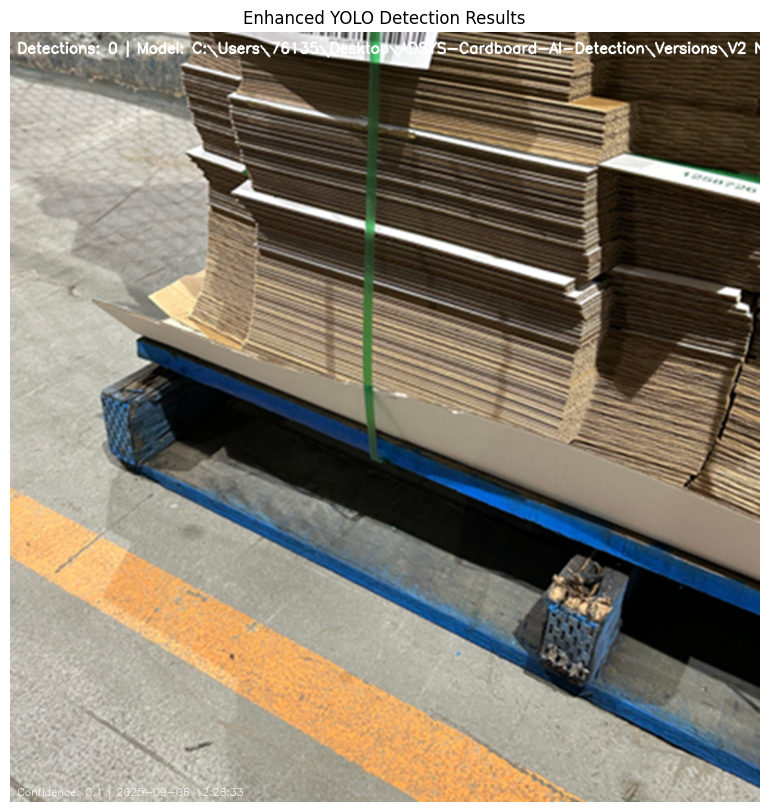

In [56]:
# Draw enhanced bounding boxes on image
result_image = image.copy()

# Add inference info overlay
font = cv2.FONT_HERSHEY_SIMPLEX
info_text = f"Detections: {len(result.boxes) if result.boxes else 0} | Model: {model_path.split('/')[-1]}"
cv2.putText(result_image, info_text, (10, 30), font, 0.7, (255, 255, 255), 2)

if result.boxes:
    # Create color palette for different classes
    colors = [(0, 255, 0), (255, 0, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255), (0, 255, 255)]
    
    for i, box in enumerate(result.boxes):
        # Get box coordinates
        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
        conf = box.conf.item()
        cls = int(box.cls.item())
        class_name = model.names[cls] if hasattr(model, 'names') and model.names else f"class_{cls}"
        
        # Choose color based on class
        color = colors[cls % len(colors)]
        thickness = 2
        
        # Draw rectangle
        cv2.rectangle(result_image, (x1, y1), (x2, y2), color, thickness)
        
        # Draw label with confidence and class ID
        label = f"{class_name} ({cls}): {conf:.2f}"
        font_scale = 0.6
        label_thickness = 1
        
        # Get text size
        (text_width, text_height), baseline = cv2.getTextSize(label, font, font_scale, label_thickness)
        
        # Draw background rectangle for text
        cv2.rectangle(result_image, (x1, y1 - text_height - 5), (x1 + text_width, y1), color, -1)
        
        # Draw text
        cv2.putText(result_image, label, (x1, y1 - 5), font, font_scale, (0, 0, 0), label_thickness)
        
        # Draw center point
        center_x = (x1 + x2) // 2
        center_y = (y1 + y2) // 2
        cv2.circle(result_image, (center_x, center_y), 4, (255, 255, 255), -1)
        cv2.circle(result_image, (center_x, center_y), 2, color, -1)
        
        # Draw width and height indicators
        cv2.line(result_image, (x1, y1 - 10), (x2, y1 - 10), (200, 200, 200), 1)
        cv2.line(result_image, (x2 + 10, y1), (x2 + 10, y2), (200, 200, 200), 1)
        
        # Draw dimensions text
        width = x2 - x1
        height = y2 - y1
        dim_text = f"{width}x{height}"
        cv2.putText(result_image, dim_text, (x2 + 15, (y1 + y2) // 2), font, 0.4, (200, 200, 200), 1)

# Add timestamp and confidence threshold info
import datetime
timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
conf_text = f"Confidence: {confidence_threshold} | {timestamp}"
cv2.putText(result_image, conf_text, (10, result_image.shape[0] - 10), font, 0.5, (255, 255, 255), 1)

# Convert to RGB for matplotlib
result_image_rgb = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)

# Display result
plt.figure(figsize=(10, 10))
plt.imshow(result_image_rgb)
plt.title('Enhanced YOLO Detection Results')
plt.axis('off')
plt.show()

In [57]:
# Additional analytics and statistics
print("\n=== DETECTION ANALYTICS ===")
if result.boxes:
    confidences = [box.conf.item() for box in result.boxes]
    classes = [int(box.cls.item()) for box in result.boxes]
    
    print(f"Total detections: {len(result.boxes)}")
    print(f"Average confidence: {np.mean(confidences):.3f}")
    print(f"Max confidence: {np.max(confidences):.3f}")
    print(f"Min confidence: {np.min(confidences):.3f}")
    
    # Class distribution
    unique_classes, class_counts = np.unique(classes, return_counts=True)
    print("\nClass distribution:")
    for cls, count in zip(unique_classes, class_counts):
        class_name = model.names[cls] if hasattr(model, 'names') and model.names else f"class_{cls}"
        print(f"  {class_name}: {count} detection(s)")
    
    # Bounding box areas
    areas = []
    for box in result.boxes:
        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
        area = (x2 - x1) * (y2 - y1)
        areas.append(area)
    
    print(f"\nBounding box statistics:")
    print(f"  Total area covered: {np.sum(areas):.0f} pixels")
    print(f"  Average box area: {np.mean(areas):.0f} pixels")
    print(f"  Largest box: {np.max(areas):.0f} pixels")
    print(f"  Smallest box: {np.min(areas):.0f} pixels")
    
    # Image coverage percentage
    image_area = image.shape[0] * image.shape[1]
    coverage_percent = (np.sum(areas) / image_area) * 100
    print(f"  Image coverage: {coverage_percent:.1f}%")
else:
    print("No detections found.")


=== DETECTION ANALYTICS ===
No detections found.


In [58]:
# Save result image
output_path = "detection_result.jpg"
cv2.imwrite(output_path, result_image)
print(f"Result saved to: {output_path}")

Result saved to: detection_result.jpg
